<a href="https://colab.research.google.com/github/ariabishma/learn-machinelearning/blob/main/Road_To_GPT_Positional_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-05-04 05:08:21--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-05-04 05:08:21 (57.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [7]:
import tensorflow as tf
import numpy as np 

In [8]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [9]:
print("length of dataset in characters: ", len(text))
print(text[:1000])

length of dataset in characters:  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hung

In [10]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Character Level Encoder - Decoder

In [11]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [12]:
data = np.array(encode(text))

## Batch Preparation

In [13]:
n = int(0.9*len(data)) # train validation split

In [14]:
train_data = data[:n]
val_data = data[n:]

In [15]:
block_size = 8 
train_data[:block_size+1]

array([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [16]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [17]:
random = np.random.randint(len(data) - block_size)
print("x : ",decode(data[random:random+block_size]))
print("y : ",decode(data[random+1:random+block_size+1]))

x :  t the pe
y :   the peo


In [18]:
batch_size = 10 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(len(data) - block_size, size = (batch_size,)) # generate random text position 
    x = np.stack([data[i:i+block_size] for i in ix])
    y = np.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')

## The Model

In [89]:
class InputEmbedding(tf.keras.layers.Layer):
    """ Input embedding + positional encoding """
    def __init__(self):
      super().__init__()
      self.input_embedding = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = vocab_size)

    def sinusoid(self,x):
      return 10
    
    def call(self,x):
      input_embedding = self.input_embedding(x) 
      positional_encoding = self.sinusoid(x)

      logits = input_embedding + positional_encoding
      
      return logits

In [88]:
embedding = InputEmbedding()
y = embedding(xb)
y.shape

TensorShape([10, 8, 65])

# Experiment

## Sinusoidal positional encoder

Formula : 

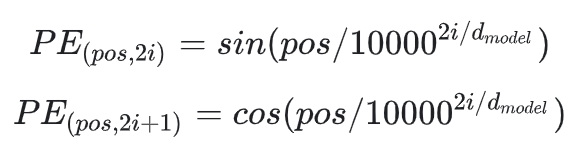


In [20]:
import numpy as np 
import matplotlib.pyplot as plt

In [21]:
batch = 4
context_length = 8
depth = 32 # embedding vector depth

In [25]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=context_length, d=depth, n=100)

pos_batch = np.array([getPositionEncoding(seq_len=context_length, d=depth) for _ in range(batch)])
print(pos_batch.shape)

(4, 8, 32)


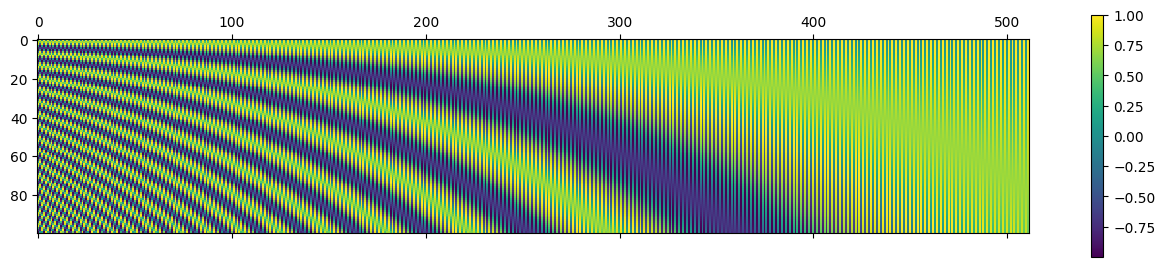

In [23]:
P = getPositionEncoding(seq_len=100, d=512, n=100)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

## Embedding layer

In [45]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,vocab_size))

In [49]:
xb.shape

(10, 8)

In [50]:
output = model.predict(xb)
output.shape

1/1 [==============================] - 0s 40ms/step


(10, 8, 65)

In [51]:
output[0]

array([[ 2.63617150e-02, -3.12223285e-03,  3.84619869e-02,
         2.67203711e-02,  4.11890484e-02, -2.59567145e-02,
         1.12951621e-02,  3.60977389e-02, -4.78334352e-03,
         2.27276795e-02,  2.57584341e-02, -3.05463914e-02,
         4.92918529e-02, -3.63522992e-02,  2.79832222e-02,
        -6.66680187e-03,  2.08204053e-02, -1.78988576e-02,
        -2.43375432e-02, -2.40281112e-02,  4.15768065e-02,
        -1.14094019e-02,  2.25137137e-02, -1.86568722e-02,
        -1.91607121e-02, -4.31557894e-02, -4.34288494e-02,
        -2.16871500e-03,  2.75940187e-02,  1.06566772e-02,
         1.03475079e-02, -3.01103126e-02, -1.47007108e-02,
         3.67862098e-02, -2.07860395e-03,  1.75896548e-02,
         6.12617657e-03, -3.82933505e-02,  7.80024379e-03,
         3.82460691e-02, -1.70785785e-02,  3.32504176e-02,
        -2.57342346e-02,  3.53039391e-02, -2.19573267e-02,
        -2.27951296e-02, -1.49579532e-02, -1.37866624e-02,
         1.29891559e-03,  1.13407597e-02, -2.34471560e-0